#**Step 1: Install All the Required Packages**

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

#**Step 2: Import All the Required Libraries**

In [16]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from transformers.optimization import AdamW, Adafactor
from sklearn.model_selection import ParameterGrid
import torch.optim as optim
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")



#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

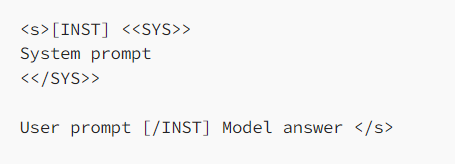

#We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

# **Convert JSONL to JSON step - Skip if you have correct file**
**Implement class code below if you need make this conversion first, but no need if you already have correct JSON format**

In [3]:
# import json
# from jsonl2json import JsonlToJsonFormatter


# def convert_to_llama2(gpt_data):
#     llama2_data = []
#     for row in gpt_data:
#         messages = row['messages']
#         reformatted_segments = []

#         for message in messages:
#             if message['role'] == 'system':
#                 inst_text = message['content']
#             elif message['role'] == 'user':
#                 human_text = message['content']
#             elif message['role'] == 'assistant':
#                 assistant_text = message['content']
#                 reformatted_segments.append(
#                     f'<s>[INST]<<SYS>> {inst_text} <</SYS>> {human_text} [/INST] {assistant_text} </s>')
#             else:
#                 reformatted_segments.append(f'<s>[INST] {human_text} [/INST] </s>')

#         llama2_data.append({'text': ''.join(reformatted_segments)})

#     return llama2_data

# #This is example class function where 'first_10.jsonl' needs conversion to 'first_10.json'
# def main():
#     # convert the jsonl to json file
#     jsonl = JsonlToJsonFormatter('first_10.jsonl', 'first_10.json')
#     jsonl.to_json()
#     # Read GPT JSON file
#     with open('first_10.json', 'r') as f:
#         gpt_json = json.load(f)

# # Convert GPT data to llama2 format
# llama2_data = convert_to_llama2(gpt_json)

# **Continue with loading correct json file here, put correct path and filename in this case /content/output_llama2.json**

In [4]:
import json
from datasets import Dataset
my_dataset=[]
# Load your dataset
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

# Example usage:
dataset_file = "/content/output_llama2.json"
my_dataset=load_dataset(dataset_file)

# Now my_dataset is a dictionary where each entry corresponds to a sample
print(my_dataset[0])

hf_dataset = Dataset.from_dict({'text': [example['text'] for example in my_dataset]})
print(hf_dataset[0])

{'text': '<s>[INST]<<SYS>> Given characteristics about a patient, where applicable, provide the APR Severity of Illness Description: <</SYS>> Provide the APR Severity of Illness Description based on values provided: Health Service Area:Capital/Adiron, Hospital County:Clinton, Operating Certificate Number:901001.0, Facility ID:135.0, Facility Name:The University of Vermont Health Network - Champlain Valley Physicians, Age Group:70 or Older, Zip Code - 3 digits:129, Gender:M, Race:White, Ethnicity:Spanish/Hispanic, Length of Stay:17, Type of Admission:Emergency, Patient Disposition:Expired, Discharge Year:2013, CCS Diagnosis Code:122, CCS Diagnosis Description:Pneumonia (except that caused by tuberculosis or sexually transmitted disease), CCS Procedure Code:0, CCS Procedure Description:NO PROC, APR DRG Code:137, APR DRG Description:Major respiratory infections & inflammations, APR MDC Description:Diseases and Disorders of the Respiratory System, APR Risk of Mortality:Major, APR Medical S

# **Extracting 50 Random samples for experimentation**

In [5]:
import random
#overring the hf_dataset to 30 new samples
random_samples = random.sample(my_dataset, 50)
hf_dataset=random_samples
#this was the fix
hf_dataset = Dataset.from_dict({'text': [example['text'] for example in random_samples]})
len(hf_dataset)


50

In [6]:
#saving 30 ranndom as json output
if isinstance(my_dataset[0], dict):
    # Elements are already dictionaries, no conversion needed.
    data_to_save = random_samples
else:
    # Elements are not dictionaries, convert to a list of dictionaries with an "item" key.
    data_to_save = [{'item': sample} for sample in random_samples]

# Save data to JSON file
with open('30_random_samples.json', 'w') as outfile:
    json.dump(data_to_save, outfile)

print("Random samples saved to 30_random_samples.json")

Random samples saved to 30_random_samples.json


In [7]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
# dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"


# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False



# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3


# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

###Experiment


In [8]:
#Creating an Eval dataset and rerunning
#selecting 10 random samples for evaluation
random_samples = random.sample(my_dataset, 10)
eval_dataset=random_samples
#this was the fix
eval_dataset = Dataset.from_dict({'text': [example['text'] for example in random_samples]})
len(eval_dataset)

10

In [22]:

num_train_epochs = 1

# Log every X updates steps
# logging_steps =   None

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

param_grid = {
    'learning_rate': [0.0001, 0.00001],
    # 'weight_decay': [0.0001, 0.00001],
    'optimizer': ['adamw','adafactor'],
    'per_device_train_batch_size':[3,2,1],
    # 'per_device_eval_batch_size':[3,2,1],
}

# Generate combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))
best_params = None
#  Training arguments with early stopping criteria

# Define early stopping criteria

patience = 1



# Train the model

for params in param_combinations:
    no_improvement_counter = 0
    best_eval_loss = float('inf')
    eval_loss=float('inf')
    training_args = TrainingArguments(
    load_best_model_at_end = True,
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    gradient_accumulation_steps=gradient_accumulation_steps,
    # save_steps=save_steps,
    # logging_steps=logging_steps,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,  # Maintain for limiting total training steps
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    # Early stopping parameters
    # Evaluate validation set every few training steps
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch'
    # Perform evaluation after each eval_steps
)

    trainer = SFTTrainer(
        model=model,
        train_dataset=hf_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        tokenizer=tokenizer,
        args=training_args,
        packing=packing
    )
    print("Parameters Selected :::",params)
    # Update training arguments with current parameter combination
    training_args.learning_rate = params['learning_rate']
    # training_args.weight_decay = params['weight_decay']
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    training_args.per_device_eval_batch_size = params['per_device_train_batch_size']
    optimizer_name = params['optimizer']

    # Set optimizer
    if optimizer_name == 'adamw':
        optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
    elif optimizer_name == 'adafactor':
        optimizer = Adafactor(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay,relative_step=False)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Assign optimizer to the Trainer object
    trainer.optimizer = optimizer

    for epoch in range(20):
        print("Number of epochs",epoch+1)
        # Train the model with current parameter combination
        trainer.train()

        # Evaluate on the validation set
        eval_results = trainer.evaluate()
        eval_loss = eval_results['eval_loss']

        # Check for improvement
        if eval_loss < best_eval_loss or eval_loss-best_eval_loss>0.05:
            best_eval_loss = eval_loss
            best_params = params.copy()
            no_improvement_counter = 0
            # Save the model if it's the best so far
            trainer.save_model("best_model")
        else:
            no_improvement_counter += 1

        # Print or store the results


        # Check if early stopping criteria are met
        if no_improvement_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping training.")
            break
    print(f"Evaluation result: {eval_results}")

print("Training complete.")
print("Best parameter combination:", best_params)
print("Best evaluation result:", best_eval_result)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'per_device_train_batch_size': 3}
Number of epochs 1


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.459300,2.344248


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,2.075200,1.952250


Number of epochs 3


Epoch,Training Loss,Validation Loss
1,1.654600,1.495861


Number of epochs 4


Epoch,Training Loss,Validation Loss
1,1.139900,0.976197


Number of epochs 5


Epoch,Training Loss,Validation Loss
1,0.713200,0.634946


Number of epochs 6


Epoch,Training Loss,Validation Loss
1,0.494400,0.480242


Number of epochs 7


Epoch,Training Loss,Validation Loss
1,0.372400,0.388783


Number of epochs 8


Epoch,Training Loss,Validation Loss
1,0.305300,0.348252


Number of epochs 9


Epoch,Training Loss,Validation Loss
1,0.269000,0.324176


Number of epochs 10


Epoch,Training Loss,Validation Loss
1,0.238800,0.303975


Number of epochs 11


Epoch,Training Loss,Validation Loss
1,0.218600,0.292276


Number of epochs 12


Epoch,Training Loss,Validation Loss
1,0.212600,0.288520


Number of epochs 13


Epoch,Training Loss,Validation Loss
1,0.204000,0.287866


Number of epochs 14


Epoch,Training Loss,Validation Loss
1,0.191400,0.290676


No improvement for 1 epochs. Stopping training.
Evaluation result: {'eval_loss': 0.29067593812942505, 'eval_runtime': 5.474, 'eval_samples_per_second': 1.827, 'eval_steps_per_second': 0.731, 'epoch': 1.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'per_device_train_batch_size': 2}
Number of epochs 1


Epoch,Training Loss,Validation Loss
1,2.342800,2.175328


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,1.779600,1.583699


Number of epochs 3


Epoch,Training Loss,Validation Loss
1,1.077200,0.860162


Number of epochs 4


Epoch,Training Loss,Validation Loss
1,0.599700,0.538069


Number of epochs 5


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.397000,0.395765


Number of epochs 6


Epoch,Training Loss,Validation Loss
1,0.304900,0.343537


Number of epochs 7


Epoch,Training Loss,Validation Loss
1,0.251700,0.295815


Number of epochs 8


Epoch,Training Loss,Validation Loss
1,0.225000,0.290234


Number of epochs 9


Epoch,Training Loss,Validation Loss
1,0.212800,0.285698


Number of epochs 10


Epoch,Training Loss,Validation Loss
1,0.203800,0.281606


Number of epochs 11


Epoch,Training Loss,Validation Loss
1,0.194500,0.281619


No improvement for 1 epochs. Stopping training.
Evaluation result: {'eval_loss': 0.28161901235580444, 'eval_runtime': 5.5425, 'eval_samples_per_second': 1.804, 'eval_steps_per_second': 0.902, 'epoch': 1.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'per_device_train_batch_size': 1}
Number of epochs 1


Epoch,Training Loss,Validation Loss
1,2.000400,1.671097


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,0.874800,0.609806


Number of epochs 3


Epoch,Training Loss,Validation Loss
1,0.400000,0.376404


Number of epochs 4


Epoch,Training Loss,Validation Loss
1,0.275700,0.302383


Number of epochs 5


Epoch,Training Loss,Validation Loss
1,0.233800,0.281474


Number of epochs 6


Epoch,Training Loss,Validation Loss
1,0.218500,0.274850


Number of epochs 7


Epoch,Training Loss,Validation Loss
1,0.203300,0.272063


Number of epochs 8


Epoch,Training Loss,Validation Loss
1,0.192400,0.279387


No improvement for 1 epochs. Stopping training.
Evaluation result: {'eval_loss': 0.279386967420578, 'eval_runtime': 6.6311, 'eval_samples_per_second': 1.508, 'eval_steps_per_second': 1.508, 'epoch': 1.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 0.0001, 'optimizer': 'adafactor', 'per_device_train_batch_size': 3}
Number of epochs 1


Epoch,Training Loss,Validation Loss
1,2.657100,2.676144


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,2.656400,2.675779


Number of epochs 3


Epoch,Training Loss,Validation Loss
1,2.655800,2.675319


Number of epochs 4


Epoch,Training Loss,Validation Loss
1,2.654900,2.674836


Number of epochs 5


Epoch,Training Loss,Validation Loss
1,2.654200,2.674363


Number of epochs 6


Epoch,Training Loss,Validation Loss
1,2.653700,2.673937


Number of epochs 7


Epoch,Training Loss,Validation Loss
1,2.653400,2.673609


Number of epochs 8


Epoch,Training Loss,Validation Loss
1,2.653200,2.673213


Number of epochs 9


Epoch,Training Loss,Validation Loss
1,2.653500,2.672723


Number of epochs 10


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:

num_train_epochs = 1

# Log every X updates steps
# logging_steps =   None

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

param_grid = {
    'learning_rate': [0.00001],
    # 'weight_decay': [0.0001, 0.00001],
    'optimizer': ['adamw'],
    'per_device_train_batch_size':[3,2,1],
    # 'per_device_eval_batch_size':[3,2,1],
}

# Generate combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))
best_params = None
#  Training arguments with early stopping criteria

# Define early stopping criteria

patience = 1



# Train the model

for params in param_combinations:
    no_improvement_counter = 0
    best_eval_loss = float('inf')
    eval_loss=float('inf')
    training_args = TrainingArguments(
    load_best_model_at_end = True,
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    gradient_accumulation_steps=gradient_accumulation_steps,
    # save_steps=save_steps,
    # logging_steps=logging_steps,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,  # Maintain for limiting total training steps
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    # Early stopping parameters
    # Evaluate validation set every few training steps
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch'
    # Perform evaluation after each eval_steps
)

    trainer = SFTTrainer(
        model=model,
        train_dataset=hf_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        tokenizer=tokenizer,
        args=training_args,
        packing=packing
    )
    print("Parameters Selected :::",params)
    # Update training arguments with current parameter combination
    training_args.learning_rate = params['learning_rate']
    # training_args.weight_decay = params['weight_decay']
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    training_args.per_device_eval_batch_size = params['per_device_train_batch_size']
    optimizer_name = params['optimizer']

    # Set optimizer
    if optimizer_name == 'adamw':
        optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
    elif optimizer_name == 'adafactor':
        optimizer = Adafactor(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay,relative_step=False)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Assign optimizer to the Trainer object
    trainer.optimizer = optimizer

    for epoch in range(20):
        print("Number of epochs",epoch+1)
        # Train the model with current parameter combination
        trainer.train()

        # Evaluate on the validation set
        eval_results = trainer.evaluate()
        eval_loss = eval_results['eval_loss']

        # Check for improvement
        if eval_loss < best_eval_loss and best_eval_loss-eval_loss>0.05:
            best_eval_loss = eval_loss
            best_params = params.copy()
            no_improvement_counter = 0
            # Save the model if it's the best so far
            trainer.save_model("best_model")
        else:
            no_improvement_counter += 1

        # Print or store the results


        # Check if early stopping criteria are met
        if no_improvement_counter >= patience:
            print(f"No improvement for {patience} epochs. Stopping training.")
            break
    print(f"Evaluation result: {eval_results}")

print("Training complete.")
print("Best parameter combination:", best_params)
print("Best evaluation result:", best_eval_result)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 1e-05, 'optimizer': 'adamw', 'per_device_train_batch_size': 3}
Number of epochs 1


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.639200,2.646981


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,2.605900,2.612138


No improvement for 1 epochs. Stopping training.
Evaluation result: {'eval_loss': 2.612138032913208, 'eval_runtime': 5.46, 'eval_samples_per_second': 1.832, 'eval_steps_per_second': 0.733, 'epoch': 1.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Parameters Selected ::: {'learning_rate': 1e-05, 'optimizer': 'adamw', 'per_device_train_batch_size': 2}
Number of epochs 1


Epoch,Training Loss,Validation Loss
1,2.629500,2.632997


Number of epochs 2


Epoch,Training Loss,Validation Loss
1,2.578400,2.577766


Number of epochs 3


Epoch,Training Loss,Validation Loss
1,2.515500,2.510770


Number of epochs 4


Epoch,Training Loss,Validation Loss
1,2.442600,2.435557


Number of epochs 5


Epoch,Training Loss,Validation Loss
1,2.362000,2.353814


Number of epochs 6


Epoch,Training Loss,Validation Loss
1,2.277400,2.267313


Number of epochs 7


Epoch,Training Loss,Validation Loss
1,2.187800,2.178550


Number of epochs 8


Epoch,Training Loss,Validation Loss
1,2.097400,2.088639


Number of epochs 9


Epoch,Training Loss,Validation Loss


In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs